In [1]:
from IPython.display import clear_output

import caffe
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

%matplotlib inline

caffe.set_device(0)
caffe.set_mode_gpu()

In [2]:
solver_path = 'solver.prototxt'
start_iter = 0

In [3]:
solver = caffe.get_solver(solver_path)

# weight = 'models/gan__iter_45000.caffemodel'
# weight = 'models/gan_v2__iter_5000.caffemodel'
# weight = 'models/new/gan_new_v1_iter_%d.caffemodel' % start_iter

# weight = 'models/gan_new_v1_iter_31000.caffemodel'
# weight = 'models/debug/train_D_iter_106000.caffemodel'
# solver.net.copy_from(weight)
# state = 'mnist_models/v1_iter_20000.solverstate'
# solver.restore(state)

In [4]:
!cat $solver_path

net: "gan_configs/train.prototxt"
display: 100

type: "Adam"
base_lr: 2e-4
lr_policy: "fixed"

momentum: 0.5
momentum2: 0.999
delta: 1e-8

snapshot_prefix: "mnist_models_adam/v1"
snapshot: 1000

gan_solver: true
use_mse_loss: false
dis_mod: 1
gen_mod: 2


# debug_info: true
# max_iter: 15000
# average_loss: 100


solver_mode: GPU


In [5]:
!cat 'gan_configs/train.prototxt'

name: "DCGAN"
#-----------   data  ------------
layer {
  name: "data"
  type: "ImageData"
  top: "data"
  top: "label"
  include {
    phase: TRAIN
  }
  transform_param {
    mirror: true
    mean_value: [127.5]
    scale: 0.00784314
  }
  image_data_param {
    source: "data/mnist_data.txt"
    # root_folder: ""
    batch_size: 64
    new_height: 64
    new_width: 64
    is_color: true
    shuffle: true
  }
}

layer {
  name: "rand_vec" 
  type: "RandVec"
  top: "rand_vec"
  rand_vec_param {
    batch_size: 64
    channel: 100
    lower: -1.0
    upper: 1.0
    repeat: 1     # every iter start a new random number
  }
}

layer {
  name: "silence"
  type: "Silence"
  bottom: "label"
}
#----------- generative -----------
layer {
  name: "conv1"  # "ip1" -> "conv1"
  type: "InnerProduct"
  bottom: "rand_vec"
  top: "ip1"
  param {
    name: "ip_w_g"
    lr_mult: 1
  }
  param {
    name: "ip_b_g"
    lr_mult: 2
  }
  inner_product_param{
    num_output: 16384  # 1024 * 4 * 4
    gen_mod

In [6]:
batch_size = 64
epoch = 500
img_num = 70000
niter = int(math.ceil(img_num / batch_size)) * epoch - start_iter

test_interval = 100
display = 100

D_acc = np.zeros(niter)

save_dir = "mnist_imgs_adam/"

In [7]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""

#     normalize data for display
#     data = (data - data.min()) / (data.max() - data.min())
    data = data * 127.5 + 127.5
    data[data < 0] = 0
    data[data > 255] = 255
    data = data.astype(np.uint8)
    data = data.transpose(0,2,3,1)    # change to nhwc
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.figure(figsize=(12,12)) 
    plt.imshow(data[...,::-1]); plt.axis('off')
    plt.show()
    return data

In [ ]:
# solver.net.blobs['rand_vec'].data[...] = np.ones((64,100))
# for i in range(64):
#     solver.net.blobs['rand_vec'].data[...][i,...] = -13
# print(solver.net.blobs['rand_vec'].data)
# solver.net.forward(start = 'ip1')
# g_img = solver.net.blobs['gen_conv5'].data
# data = np.array(g_img)
# data = vis_square(data)
g_loss = []
d_loss = []

Iteration  116600 for  D        Epoch  106


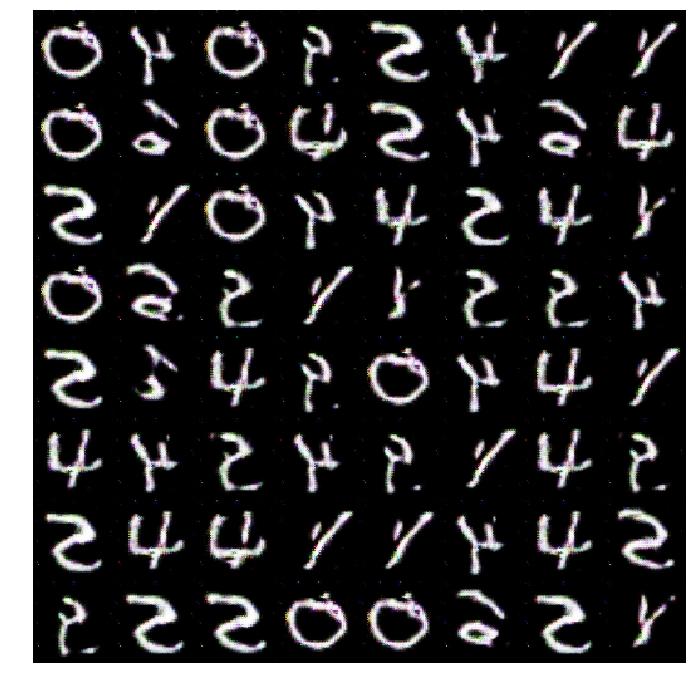

In [ ]:
d_iter = 1
g_iter = 1
for it in range(start_iter,start_iter+niter):
    solver.step(1)
#     if it % 2:
#         g_iter = g_iter + 1
#         if (g_iter-1) % 2:
# #             print "Iteration ",it, "for ",'G  pass!!!',g_iter
#             continue
#     else:
#         d_iter = d_iter + 1
    
#     c1 = solver.net.params['gan_loss'][0].data
#     c2 = solver.net.params['gan_loss'][1].data
#     c3 = solver.net.params['gan_loss'][2].data
    loss = solver.net.params['gan_loss'][3].data
    if it % 2:
        g_loss.append(float(loss))
    else:
        d_loss.append(float(loss))
    
    if it % display == 0:
        clear_output()
        g_img = solver.net.blobs['gen_conv5'].data
        data = np.array(g_img)
        cur_epoch = int(it/(math.ceil(img_num / batch_size)))
        print "Iteration ",it, "for ", 'G' if it % 2 else 'D', "       Epoch ", cur_epoch
        data = vis_square(data)
        cv2.imwrite(save_dir + "iter_%d_epoch_%d.png" % (it,cur_epoch) , data)
# print(g_loss)
# print(d_loss)


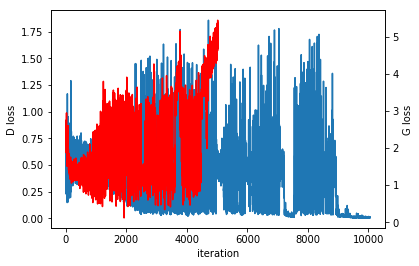

In [10]:
_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(len(d_loss)), d_loss)
# 红: g_loss  蓝: d_loss
ax2.plot(np.arange(len(g_loss)), g_loss, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('D loss')
ax2.set_ylabel('G loss')